In [5]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd

import json
import glob
import os
import re

from shared import *

In [2]:
base = "../exp/"
paths = glob.glob(base + "ubs_perf/*.json")
data = [json.load(open(path)) for path in paths]

In [3]:
ubs_checks = pd.DataFrame.from_records([{
    **algo,
    'graph': path_to_graph(run['args'][1]),
    'metric': run['live_weight_file']
} for run in data for algo in run['algo_runs']])

In [11]:
ubs_checks.groupby(['algo', 'rank'])['num_nodes_on_path'].describe()

count         mean         std     min      25%     50%  \
algo          rank                                                            
dijkstra_tree 0     427.0     1.000000    0.000000     1.0     1.00     1.0   
              1     476.0     2.000000    0.000000     2.0     2.00     2.0   
              2     423.0     3.018913    0.619296     2.0     3.00     3.0   
              3     440.0     4.852273    1.294282     2.0     4.00     5.0   
              4     456.0     8.061404    2.643790     2.0     6.00     8.0   
...                   ...          ...         ...     ...      ...     ...   
sse_rphast    17    520.0   760.878846  205.363409   391.0   613.75   726.0   
              18    547.0  1067.418647  303.333027   523.0   858.00  1011.0   
              19    575.0  1488.913043  392.843604   692.0  1202.00  1446.0   
              20    541.0  2019.000000  499.401227  1103.0  1672.00  1941.0   
              21    625.0  3005.462400  631.852244  1585.0  2540.00  2965.0   

                        75%     max  
algo          rank                   
dijkstra_tree 0        1.00     1.0  
              1        2.00     2.0  
              2        3.00     4.0  
              3        6.00     8.0  
              4        9.00    16.0  
...                     ...     ...  
sse_rphast    17     884.25  1481.0  
              18    1215.50  2642.0  
              19    1694.50  2682.0  
              20    2332.00  4028.0  
              21    3349.00  4916.0  

[88 rows x 8 columns]

In [12]:
ubs_checks.query('rank > 9').groupby(['algo', 'rank'])['running_time_ms'].describe()

count         mean          std    min    25%     50%  \
algo              rank                                                          
dijkstra_tree     10    485.0     0.043299     0.257494    0.0    0.0     0.0   
                  11    463.0     0.123110     0.431404    0.0    0.0     0.0   
                  12    470.0     0.612766     1.050458    0.0    0.0     0.0   
                  13    483.0     1.747412     2.275243    0.0    0.0     1.0   
                  14    500.0     5.506000    11.363813    0.0    2.0     4.0   
                  15    494.0    11.115385    11.571843    0.0    5.0     8.0   
                  16    514.0    25.410506    27.765110    2.0   10.0    18.0   
                  17    520.0    70.384615   122.271257    4.0   24.0    43.5   
                  18    547.0   138.974406   145.769297   15.0   60.0   105.0   
                  19    575.0   367.245217   462.985292   30.0  165.5   272.0   
                  20    541.0  1041.476895  1647.660470   52.0  408.0   704.0   
                  21    625.0  2413.032000  6332.446992  157.0  674.0  1140.0   
lazy_rphast_naive 10    485.0     1.758763     1.177242    0.0    1.0     2.0   
                  11    463.0     2.671706     1.543103    0.0    2.0     2.0   
                  12    470.0     4.042553     2.132672    0.0    2.0     4.0   
                  13    483.0     5.602484     2.774243    1.0    4.0     5.0   
                  14    500.0     8.326000     3.557110    1.0    6.0     8.0   
                  15    494.0    12.180162     5.191459    2.0    9.0    11.0   
                  16    514.0    18.517510     7.803676    4.0   13.0    17.5   
                  17    520.0    29.061538    11.552013    6.0   21.0    28.0   
                  18    547.0    47.539305    19.187999   13.0   34.0    44.0   
                  19    575.0    84.878261    37.873655   22.0   58.0    78.0   
                  20    541.0   143.510166    57.871364   42.0   99.0   136.0   
                  21    625.0   291.340800   116.251457   73.0  203.0   280.0   
lazy_rphast_tree  10    485.0     0.000000     0.000000    0.0    0.0     0.0   
                  11    463.0     0.000000     0.000000    0.0    0.0     0.0   
                  12    470.0     0.002128     0.046127    0.0    0.0     0.0   
                  13    483.0     0.008282     0.090720    0.0    0.0     0.0   
                  14    500.0     0.016000     0.154245    0.0    0.0     0.0   
                  15    494.0     0.038462     0.230834    0.0    0.0     0.0   
                  16    514.0     0.066148     0.311417    0.0    0.0     0.0   
                  17    520.0     0.282692     1.006189    0.0    0.0     0.0   
                  18    547.0     0.356490     0.958368    0.0    0.0     0.0   
                  19    575.0     0.707826     2.259673    0.0    0.0     0.0   
                  20    541.0     1.587800     3.661886    0.0    0.0     1.0   
                  21    625.0     3.270400    10.655240    0.0    0.0     1.0   
sse_rphast        10    485.0     0.356701     0.601806    0.0    0.0     0.0   
                  11    463.0     0.665227     0.632986    0.0    0.0     1.0   
                  12    470.0     1.051064     0.792791    0.0    1.0     1.0   
                  13    483.0     1.412008     0.941230    0.0    1.0     1.0   
                  14    500.0     2.054000     0.978263    0.0    1.0     2.0   
                  15    494.0     3.038462     1.418702    0.0    2.0     3.0   
                  16    514.0     4.628405     2.006823    1.0    3.0     4.0   
                  17    520.0     6.971154     2.784684    1.0    5.0     7.0   
                  18    547.0    11.471664     4.698669    3.0    8.0    11.0   
                  19    575.0    19.238261     7.747581    5.0   14.0    18.0   
                  20    541.0    31.456562    12.320281    9.0   22.0    30.0   
                  21    625.0    59.841600    22.320269

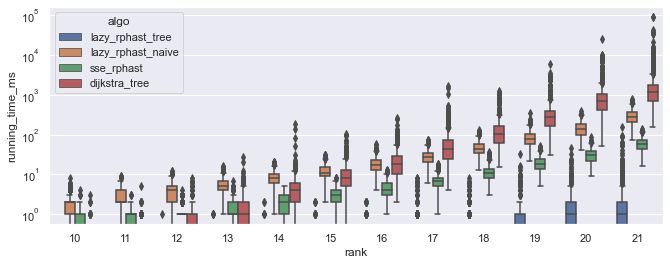

In [9]:
plt.figure(figsize=(11,4))
g = sns.boxplot(data=ubs_checks.query('rank > 9'), x='rank', y='running_time_ms', hue='algo')
g.set_yscale('log')